In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression




In [3]:
future = pd.read_excel("data/futures.xlsx", header=0)

In [4]:
future["date"]= pd.to_datetime(future["date"])
future.ffill(inplace=True)
future = future[future['date'] <= "2023-01-01"]
future.head()

,date,TRFRBYc1,TRFRBMc1,TRFRBFVMG6,TRFRBFVMH6,TRFRBFVMJ6,TRFRBFVMK6,TRFRBFVMM6,TRFRBFVMN6,TRFRBFVMQ6,...,TRFRBFVMH7,TRFRBFVMJ7,TRFRBFVMK7,TRFRBFVMM7,TRFRBFVMN7,TRFRBFVMQ7,TRFRBFVMU7,TRFRBFVMV7,TRFRBFVMX7,TRFRBFVMZ7
789,2022-12-30,245.00,202.0,162.85,147.12,115.84,103.95,101.40,102.91,110.96,...,135.40,105.99,92.64,92.72,94.45,100.84,117.78,152.02,163.86,162.26
790,2022-12-29,269.75,230.0,161.31,145.57,114.32,102.43,99.88,101.27,109.32,...,134.56,104.78,91.57,91.86,93.21,99.71,116.73,151.04,162.93,161.33
791,2022-12-28,274.00,240.0,166.20,151.23,109.20,99.74,97.55,98.32,106.83,...,141.58,99.22,88.97,90.63,91.19,97.40,112.55,159.32,168.87,166.42
792,2022-12-27,276.00,266.0,168.71,153.69,108.19,98.71,96.48,97.22,105.71,...,143.68,98.29,88.26,89.80,90.48,96.64,111.50,158.52,168.02,165.58
793,2022-12-26,276.00,266.0,166.46,156.30,95.84,93.83,91.22,90.94,101.84,...,139.45,78.74,78.48,80.38,79.59,86.55,93.88,158.16,158.22,156.62


In [5]:
# Lecture et traitement des fichiers Spot22, Spot23, Spot24, Spot25
spot_files = ["data/spot_price_16.xlsx","data/spot_price_17.xlsx","data/spot_price_18.xlsx","data/spot_price_19.xlsx","data/spot_price_20.xlsx","data/spot_price_21.xlsx","data/spot_price_22.xlsx", "data/spot_price_23.xlsx", "data/spot_price_24.xlsx", "data/spot_price_25.xlsx"]
spot_data = []

for file in spot_files:
    spot = pd.read_excel(file)
    spot['Date'] = spot['Date'].str.split(' - ').str[0]  # Prendre uniquement le début de la plage
    spot['Date'] = pd.to_datetime(spot['Date'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    spot = spot.dropna(subset=['Date'])  # Suppression des lignes avec des dates invalides
    daily = spot.groupby(spot['Date'].dt.date)['Day-ahead'].mean().reset_index()
    daily.rename(columns={'Date': 'date', 'Day-ahead': 'price'}, inplace=True)
    spot_data.append(daily)

# Fusion des bases de données
spot_merged = pd.concat(spot_data).groupby('date', as_index=False)['price'].mean()

# Affichage des premières lignes du résultat
spot_merged.head()


,date,price
0,2016-01-01,23.888750
1,2016-01-02,23.198750
2,2016-01-03,18.003750
3,2016-01-04,28.229583
4,2016-01-05,33.877083


In [6]:
spot_merged.loc[spot_merged['price'] <= 0, 'price'] = np.nan
spot_merged['price'] = spot_merged['price'].ffill()

# I. Modélisation du spot

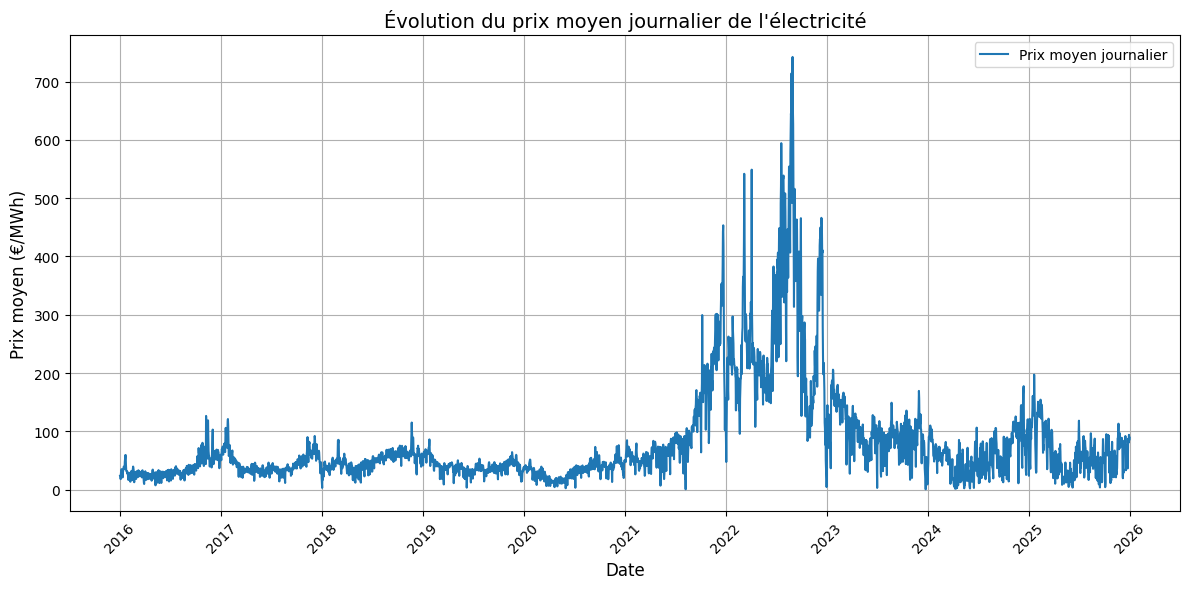

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Convertir la colonne 'date' en type datetime64 pour éviter les incompatibilités de types
spot_merged['date'] = pd.to_datetime(spot_merged['date'])

# Filtrer les données pour conserver uniquement les dates à partir du 1er janvier 2023
spot_merged = spot_merged[spot_merged['date'] >= pd.Timestamp('2023-01-01')]


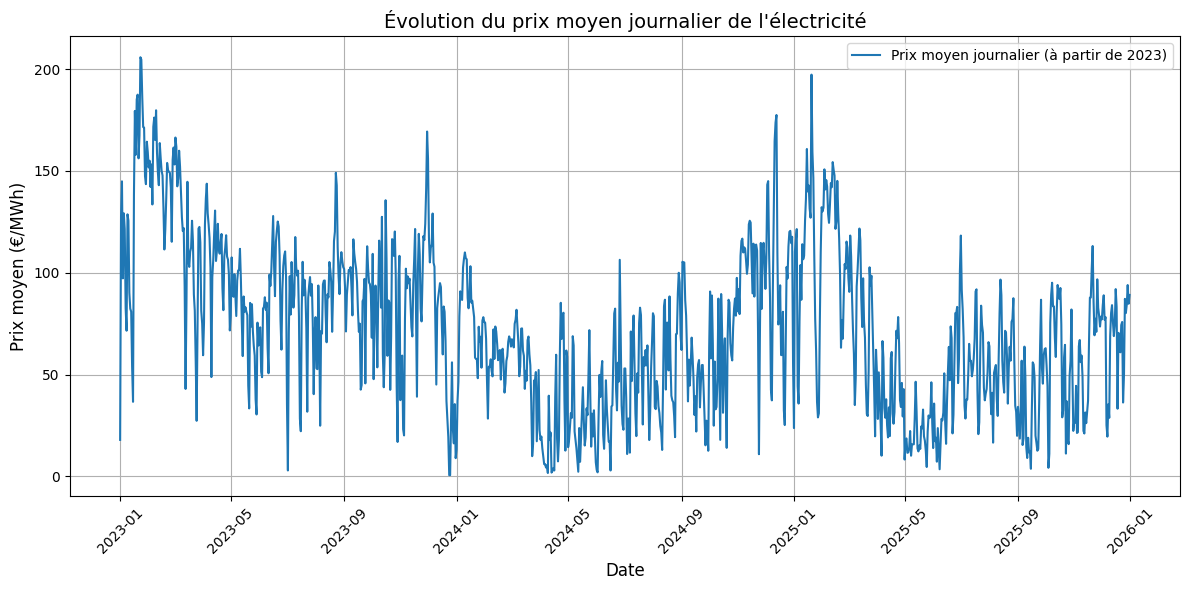

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier (à partir de 2023)')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Ajouter des colonnes "jour", "mois", "semaine" et "saison"
spot_merged['jour'] = spot_merged['date'].dt.day_name()
spot_merged['mois'] = spot_merged['date'].dt.month_name()
spot_merged['semaine'] = spot_merged['date'].dt.isocalendar().week
spot_merged['saison'] = spot_merged['date'].dt.month % 12 // 3 + 1
spot_merged['saison'] = spot_merged['saison'].map({1: 'Hiver', 2: 'Printemps', 3: 'Été', 4: 'Automne'})


Statistiques descriptives par jour de la semaine:
           count       mean        std        min        25%        50%  \
jour                                                                      
Friday     156.0  77.547948  37.992099   6.008333  54.388229  78.793073   
Monday     157.0  76.072197  40.311244   0.600000  46.892917  73.590417   
Saturday   156.0  61.733245  36.331542   1.858750  31.779896  56.751875   
Sunday     157.0  51.744751  37.181654   0.597500  19.778750  45.536667   
Thursday   156.0  79.254841  39.663877   7.231667  52.840833  80.168281   
Tuesday    157.0  79.423432  40.004813   1.659167  49.847917  77.178333   
Wednesday  157.0  80.163034  38.417830  13.785417  51.245417  82.275833   

                  75%         max  
jour                               
Friday      99.009062  187.445833  
Monday     101.276667  205.830000  
Saturday    86.250208  156.182500  
Sunday      74.291250  167.334167  
Thursday   105.515104  185.080833  
Tuesday    105.366250 

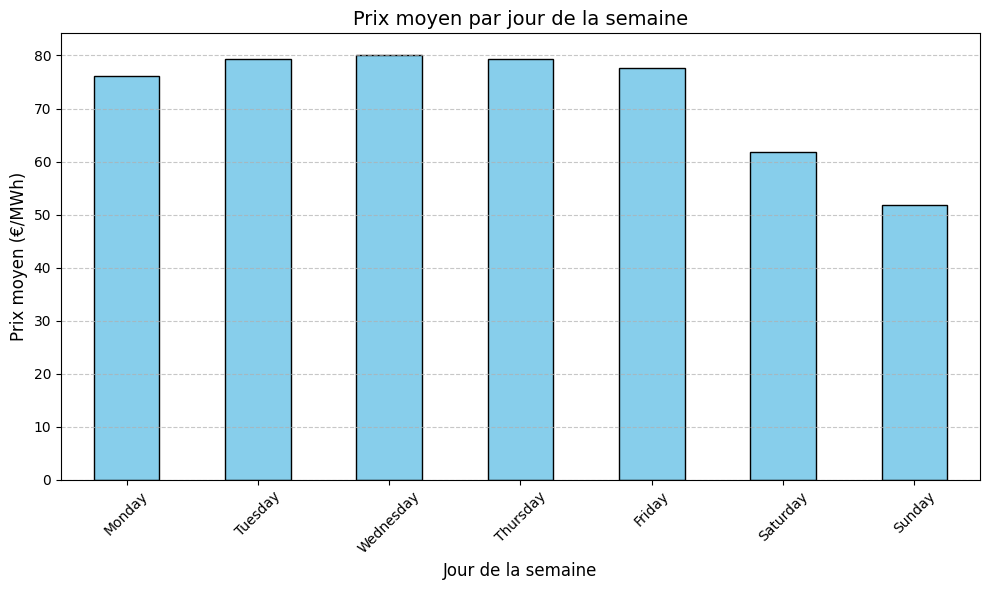

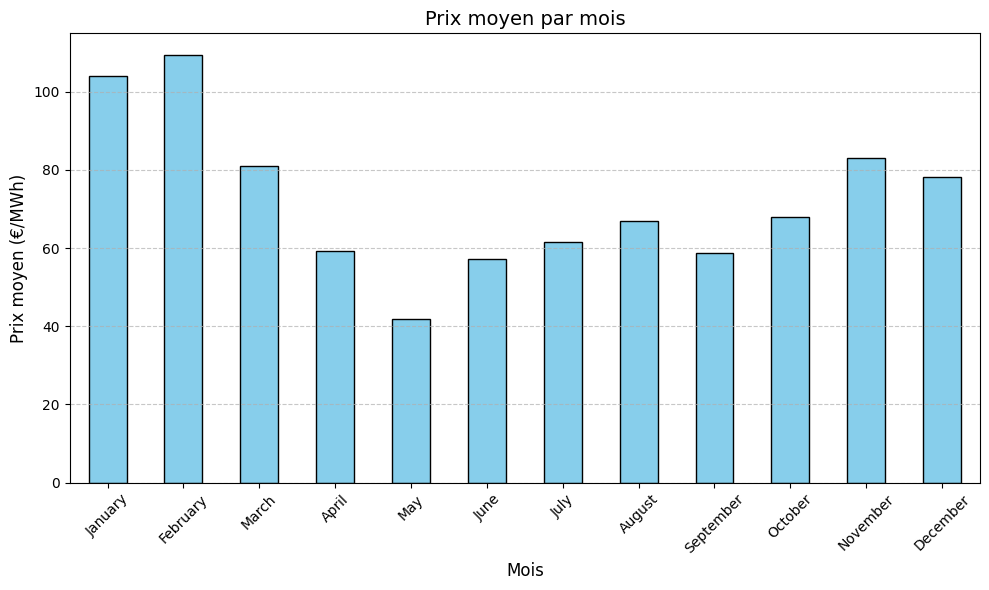

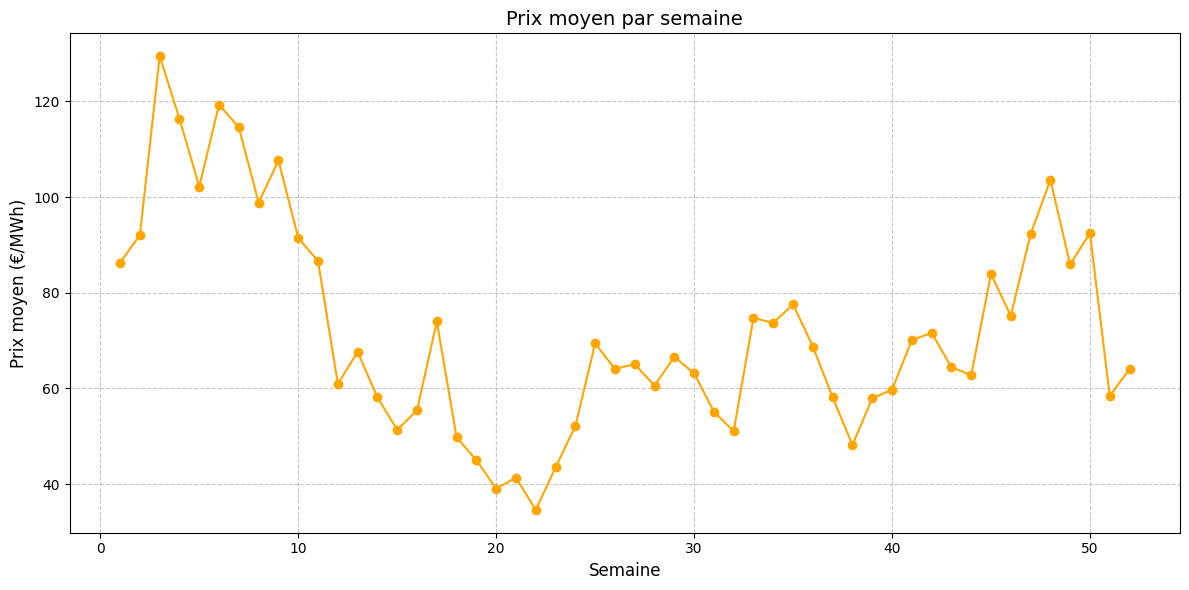

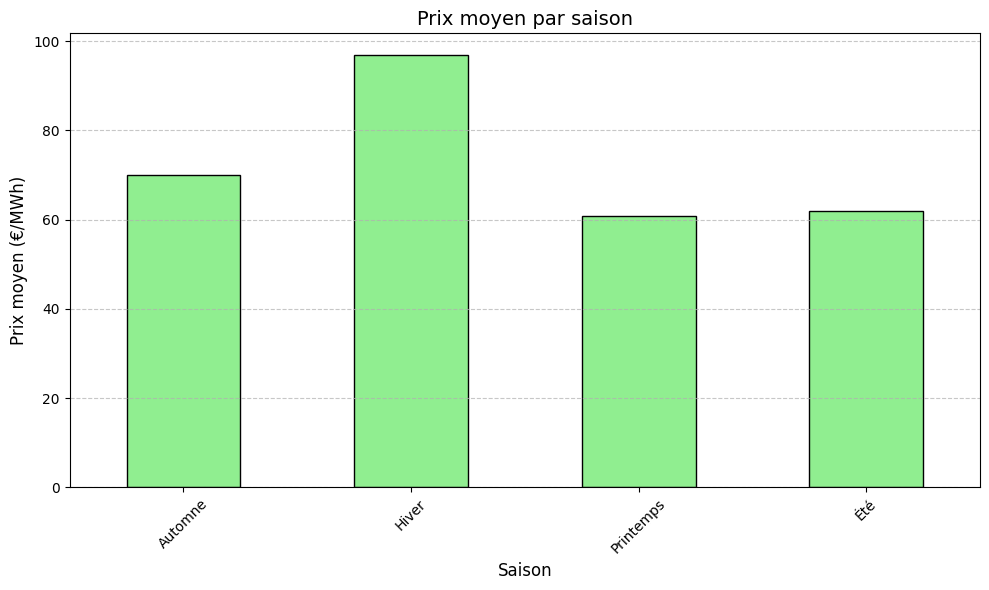

<Figure size 1200x800 with 0 Axes>

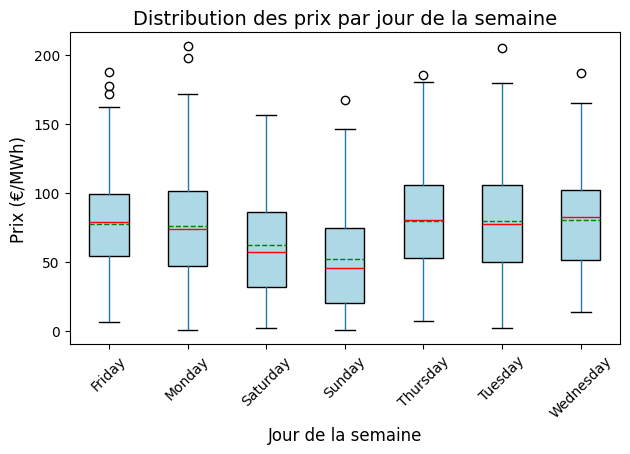

<Figure size 1200x800 with 0 Axes>

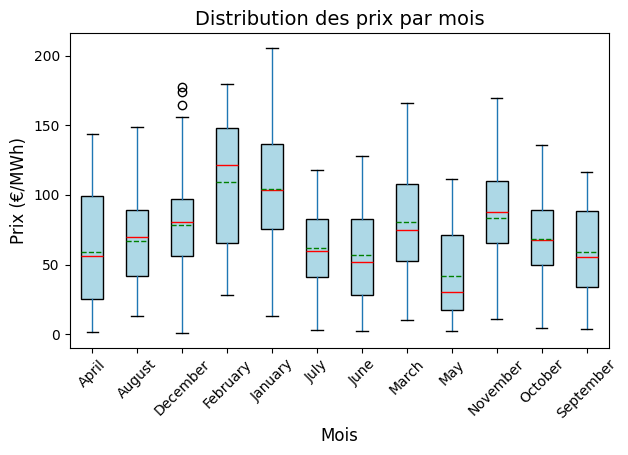

<Figure size 1200x800 with 0 Axes>

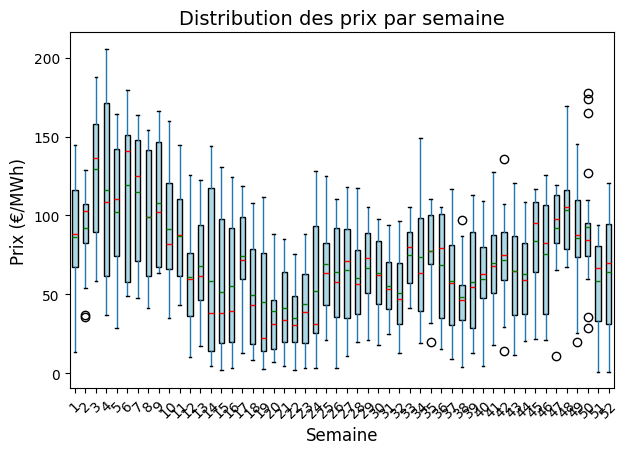

<Figure size 1200x800 with 0 Axes>

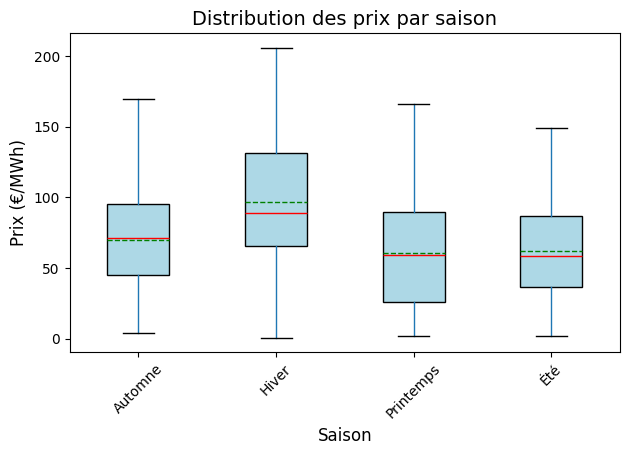

In [11]:
# Statistiques descriptives pour mesurer la saisonnalité par jour, mois, semaine et saison
stats_by_day = spot_merged.groupby('jour')['price'].describe()
stats_by_month = spot_merged.groupby('mois')['price'].describe()
stats_by_week = spot_merged.groupby('semaine')['price'].describe()
stats_by_season = spot_merged.groupby('saison')['price'].describe()

print("Statistiques descriptives par jour de la semaine:")
print(stats_by_day)
print("\nStatistiques descriptives par mois:")
print(stats_by_month)
print("\nStatistiques descriptives par semaine:")
print(stats_by_week)
print("\nStatistiques descriptives par saison:")
print(stats_by_season)

# Graphique de la moyenne des prix par jour de la semaine
plt.figure(figsize=(10, 6))
spot_merged.groupby('jour')['price'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par jour de la semaine", fontsize=14)
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par mois
plt.figure(figsize=(10, 6))
spot_merged.groupby('mois')['price'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par mois", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par semaine
plt.figure(figsize=(12, 6))
spot_merged.groupby('semaine')['price'].mean().plot(color='orange', linestyle='-', marker='o')
plt.title("Prix moyen par semaine", fontsize=14)
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par saison
plt.figure(figsize=(10, 6))
spot_merged.groupby('saison')['price'].mean().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Prix moyen par saison", fontsize=14)
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par jour de la semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='jour', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par jour de la semaine", fontsize=14)
plt.suptitle("")  # Supprimer le titre par défaut de boxplot
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par mois
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='mois', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par mois", fontsize=14)
plt.suptitle("")
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='semaine', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par semaine", fontsize=14)
plt.suptitle("")
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par saison
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='saison', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par saison", fontsize=14)
plt.suptitle("")
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On calcule les log-prix et la position temporelle dans l'année

In [12]:
spot_merged['log_price'] = np.log(spot_merged['price'])
spot_merged['t_years'] = np.arange(len(spot_merged)) / 365

### 1. Désaisonnalisation et Filtrage (Méthode Benth et al. 2012)

Afin d'extraire la composante déterministe (saisonnalité + tendance) tout en évitant que les pics de prix extrêmes (*spikes*) ne biaisent l'estimation, nous suivons la méthodologie décrite par **Benth, Kiesel & Nazarova**. Contrairement à une simple série de Fourier, cette approche intègre une tendance linéaire et un pré-traitement des données.

#### A. Modèle de Tendance $\mu(t)$
La fonction de tendance retenue inclut une composante linéaire (pour capturer l'évolution structurelle des coûts) et deux harmoniques (annuelle et semi-annuelle) :

$$
\mu(t) = \alpha + \gamma \cos(\epsilon + 2\pi t) + \delta \cos(\zeta + 4\pi t)
$$

Où :
* $\alpha$ : Niveau de base (coût fixe de production).
* $\beta t$ : Tendance linéaire à long terme (inflation, fuel switching).
* $\gamma, \epsilon$ : Amplitude et phase de la saisonnalité **annuelle** (12 mois).
* $\delta, \zeta$ : Amplitude et phase de la saisonnalité **semi-annuelle** (capture les variations hiver/été).

#### B. Algorithme de Calibration (Filtrage Préalable)
Les auteurs soulignent que la présence de *spikes* violents peut fausser l'estimation des moindres carrés. La procédure de calibration se fait donc en trois étapes :

1.  **Lissage :** Calcul d'une moyenne mobile centrée sur une fenêtre glissante de **30 jours**.
2.  **Filtrage des Outliers :** Si l'écart absolu entre le log-prix réel et la moyenne mobile dépasse un seuil de **0.5**, la valeur est considérée comme un *outlier* et remplacée par la moyenne lissée. Cette substitution est temporaire et sert uniquement à la calibration.
3.  **Estimation :** Les paramètres de $\mu(t)$ sont estimés sur cette série "nettoyée" via un ajustement aux moindres carrés non-linéaires (*Non-linear Least Squares*).

Une fois la tendance $\mu(t)$ calibrée, la série stochastique désaisonnalisée $X_t$ est obtenue en soustrayant la tendance aux **prix originaux** (en conservant les spikes) :

$$
X_t = \ln(S_t) - \mu(t)
$$

Préfiltrage

In [13]:
# Calcul de la moyenne mobile
window_size = 30
spot_merged['log_price_smooth'] = spot_merged['log_price'].rolling(window=window_size, center=True, min_periods=1).mean()

# Remplacement des outliers pour la calibration
# On crée une série temporaire juste pour fitter la tendance
spot_merged['log_price_for_fit'] = spot_merged['log_price'].copy()

# Masque des outliers
outlier_mask = np.abs(spot_merged['log_price'] - spot_merged['log_price_smooth']) > 0.5
num_filtered = outlier_mask.sum()

# Remplacement
spot_merged.loc[outlier_mask, 'log_price_for_fit'] = spot_merged.loc[outlier_mask, 'log_price_smooth']

In [14]:
# mu(t) = alpha + beta*t + gamma*cos(epsilon + 2*pi*t) + delta*cos(zeta + 4*pi*t)
def seasonality_func(t, alpha, gamma, epsilon, delta, zeta):
    term1 = alpha
    term2 = gamma * np.cos(epsilon + 2 * np.pi * t) # Saisonnalité annuelle
    term3 = delta * np.cos(zeta + 4 * np.pi * t)    # Saisonnalité semi-annuelle
    return term1 + term2 + term3

# On fit la fonction sur les données filtrées
p0_guess = [
    spot_merged['log_price'].mean(),
    0.0, 0.0,
    0.2, 0.0
]

# Optimisation
params_opt, params_cov = curve_fit(
    seasonality_func,
    spot_merged['t_years'].values,
    spot_merged['log_price_for_fit'].values,
    p0=p0_guess
)

alpha_fit, gamma_fit, eps_fit, delta_fit, zeta_fit = params_opt
print(f"Alpha : {alpha_fit:.4f}")
print(f"Gamma : {gamma_fit:.4f}")
print(f"Epsilon : {eps_fit:.4f}")
print(f"Delta : {delta_fit:.4f}")
print(f"Zeta : {zeta_fit:.4f}")


Alpha : 4.1170
Gamma : 0.3647
Epsilon : 0.1875
Delta : 0.2579
Zeta : -1.1414


In [15]:
spot_merged['seasonality_trend'] = seasonality_func(spot_merged['t_years'].values, *params_opt)

# On soustrait la tendance aux log-prix originaux
# Xt = log(St) - mu(t)
spot_merged['Xt'] = spot_merged['log_price'] - spot_merged['seasonality_trend']


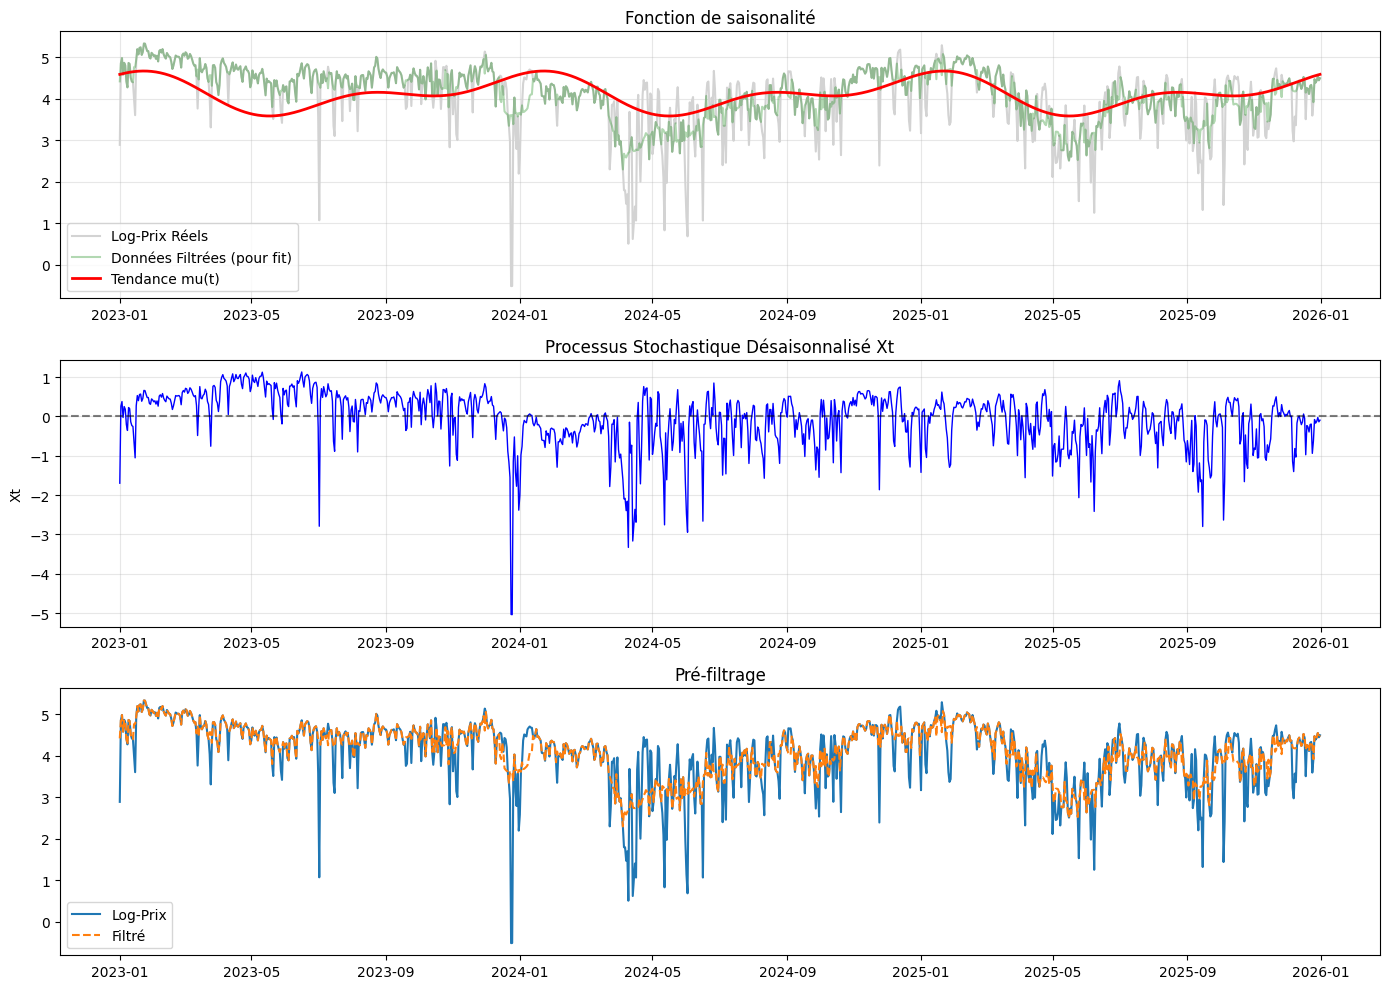

In [16]:
plt.figure(figsize=(14, 10))

# Prix originaux vs Tendance Estimée
plt.subplot(3, 1, 1)
plt.plot(spot_merged['date'], spot_merged['log_price'], color='lightgray', label='Log-Prix Réels')
plt.plot(spot_merged['date'], spot_merged['log_price_for_fit'], color='green', alpha=0.3, label='Données Filtrées (pour fit)')
plt.plot(spot_merged['date'], spot_merged['seasonality_trend'], color='red', linewidth=2, label='Tendance mu(t)')
plt.title("Fonction de saisonalité")
plt.legend()
plt.grid(True, alpha=0.3)

# Processus Désaisonnalisé Xt
plt.subplot(3, 1, 2)
plt.plot(spot_merged['date'], spot_merged['Xt'], color='blue', linewidth=1)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title("Processus Stochastique Désaisonnalisé Xt")
plt.ylabel("Xt")
plt.grid(True, alpha=0.3)

# filtrage
plt.subplot(3, 1, 3)
plt.plot(spot_merged['date'], spot_merged['log_price'], label='Log-Prix')
plt.plot(spot_merged['date'], spot_merged['log_price_for_fit'], label='Filtré', linestyle='--')
plt.title("Pré-filtrage")
plt.legend()

plt.tight_layout()
plt.show()

### 2. Détection et Filtrage des Sauts (Algorithme Récursif)

Une fois la composante saisonnière retirée, nous obtenons le processus stochastique $X_t$. Ce processus est modélisé comme une diffusion avec retour à la moyenne perturbée par des sauts (*Mean-Reverting Jump Diffusion*). Pour calibrer correctement \sigma sans qu'il soit biaisé par les valeurs extrêmes, il est indispensable de séparer les sauts du "bruit normal".

Nous appliquons ici la méthode de filtrage itératif décrite par **Cartea & Figueroa (2005)** et reprise par **Benth et al. (2012)**.

#### Algorithme de détection :
Le principe repose sur la règle des "3-sigmas" appliquée récursivement :

1.  Calculer la moyenne $\mu$ et l'écart-type $\sigma$ des variations journalières de la série $X_t$.
2.  Identifier les points dont la variation absolue dépasse un seuil critique (fixé à **$3\sigma$**).
3.  Considérer ces points comme des **sauts** ($J$) et les retirer temporairement de l'échantillon.
4.  Répéter le calcul ($\mu, \sigma$) sur la série restante. Comme les valeurs extrêmes ont été retirées, l'écart-type diminue, ce qui permet de détecter des sauts plus petits lors de l'itération suivante.
5.  L'algorithme s'arrête lorsqu'aucun nouveau saut n'est détecté.

À l'issue de ce processus, nous obtenons deux jeux de données distincts :
* Une série **"nettoyée"** (la diffusion pure) pour estimer la volatilité $\sigma$.
* Une série de **sauts** isolés pour estimer la fréquence de saut $l$ et la distribution des amplitudes ($\mu_J, \sigma_J$).

In [17]:
# Variations journalières du processus désaisonnalisé Xt
# dx_t correspond approximativement à X(t+1) - X(t)
dx = spot_merged['Xt'].diff().dropna()

clean_dx = dx.copy()
jumps_indices = []
iteration = 0
SIGMA_THRESHOLD = 3.0

while True:
    iteration += 1
    mu = clean_dx.mean()
    std = clean_dx.std()

    # Critère de détection : Variation > 3 * écart-type actuel
    # On utilise la valeur absolue
    is_jump = np.abs(clean_dx - mu) > SIGMA_THRESHOLD * std

    # Condition d'arrêt : Si aucun nouveau saut n'est trouvé, on stoppe
    if not is_jump.any():
        break

    # On sauvegarde les sauts trouvés
    new_jumps = clean_dx[is_jump]
    jumps_indices.extend(new_jumps.index)

    clean_dx = clean_dx[~is_jump]

# Résultats
print(f"Itérations : {iteration}")
print(f"Nombre total de sauts détectés : {len(jumps_indices)}")

# On marque les sauts dans le DataFrame principal pour usage futur
spot_merged['is_jump'] = False
spot_merged.loc[jumps_indices, 'is_jump'] = True

Itérations : 9
Nombre total de sauts détectés : 53


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1672/2815471824.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.scatter(spot_merged.loc[jumps_indices, 'date'], dx[jumps_indices], color='red', marker='x', s=40, label='Sauts détectés (> 3$\sigma$)', zorder=5)
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1672/2815471824.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(threshold_up, color='green', linestyle='--', alpha=0.8, label=f'Seuil (+{SIGMA_THRESHOLD}$\sigma$)')
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1672/2815471824.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(threshold_down, color='green', linesty

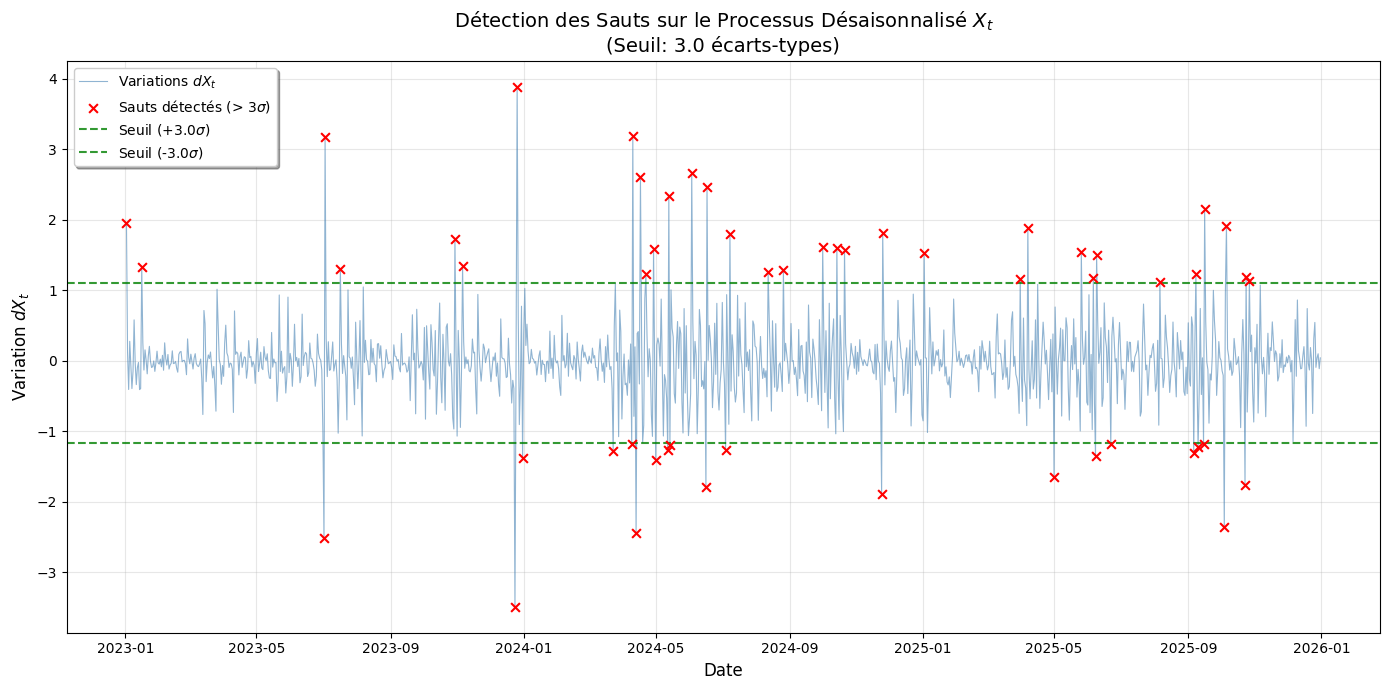

In [18]:
final_std = clean_dx.std()
final_mu = clean_dx.mean()
threshold_up = final_mu + SIGMA_THRESHOLD * final_std
threshold_down = final_mu - SIGMA_THRESHOLD * final_std

plt.figure(figsize=(14, 7))

plt.plot(spot_merged['date'].iloc[1:], dx,color='steelblue', alpha=0.6, linewidth=0.8, label='Variations $dX_t$')
plt.scatter(spot_merged.loc[jumps_indices, 'date'], dx[jumps_indices], color='red', marker='x', s=40, label='Sauts détectés (> 3$\sigma$)', zorder=5)
plt.axhline(threshold_up, color='green', linestyle='--', alpha=0.8, label=f'Seuil (+{SIGMA_THRESHOLD}$\sigma$)')
plt.axhline(threshold_down, color='green', linestyle='--', alpha=0.8, label=f'Seuil (-{SIGMA_THRESHOLD}$\sigma$)')

plt.title(f"Détection des Sauts sur le Processus Désaisonnalisé $X_t$\n(Seuil: {SIGMA_THRESHOLD} écarts-types)", fontsize=14)
plt.ylabel("Variation $dX_t$", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Nombre de sauts : 53
l : 17.67 sauts/an
Moyenne (Mu_J)     : 0.4957
Volatilité (Sigma_J): 1.8092


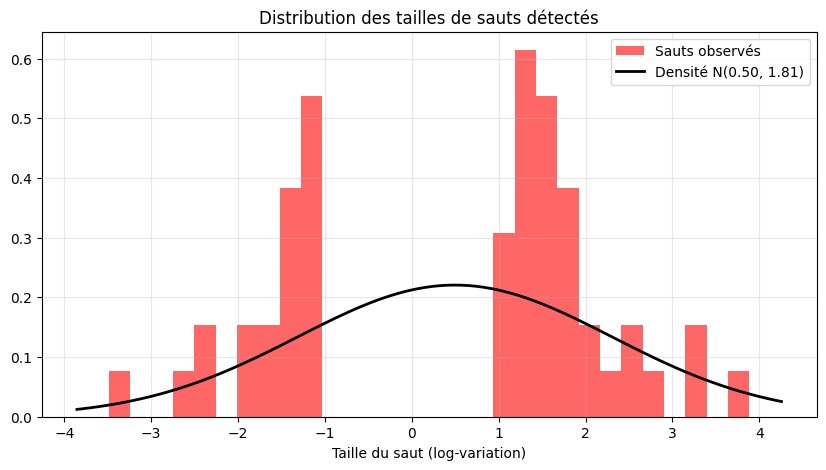

In [19]:
jump_values = dx.loc[jumps_indices]

mu_J = jump_values.mean()
sigma_J = jump_values.std()

nb_years = (spot_merged['date'].max() - spot_merged['date'].min()).days / 365
lambda_J = len(jump_values) / nb_years

print(f"Nombre de sauts : {len(jump_values)}")
print(f"l : {lambda_J:.2f} sauts/an")
print(f"Moyenne (Mu_J)     : {mu_J:.4f}")
print(f"Volatilité (Sigma_J): {sigma_J:.4f}")

# Visualisation de la distribution des sauts (Histogramme)
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(10, 5))
# Histogramme des sauts
count, bins, ignored = plt.hist(jump_values, 30, density=True, alpha=0.6, color='red', label='Sauts observés')

# Courbe théorique Normale
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu_J, sigma_J)
plt.plot(x, p, 'k', linewidth=2, label=f'Densité N({mu_J:.2f}, {sigma_J:.2f})')

plt.title("Distribution des tailles de sauts détectés")
plt.xlabel("Taille du saut (log-variation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



### 3. Modélisation de la Volatilité $\sigma(t)$

La section 5.2.1 de Benth et al. (2012) critique l'hypothèse de volatilité constante ou purement historique. Les marchés de l'électricité présentent une structure de volatilité complexe :
1.  **Saisonnalité :** La volatilité est souvent plus élevée en hiver (tensions sur la demande pour le chauffage) ou en été (canicule et climatisation).
2.  **Clustering :** Les périodes de forte agitation ont tendance à se regrouper (effet de persistance).

Cartea et Figueroa suggèrent d'utiliser une volatilité dépendante du temps. Nous calculons d'abord la **volatilité historique glissante** (*Rolling Historical Volatility*) sur une fenêtre de 30 jours, telle que suggérée par Eydeland et Wolyniec (2002).

Cependant, comme le souligne Benth et al. (voir Fig. 3 de leur papier), cette volatilité historique présente un motif saisonnier clair qu'il convient de modéliser pour les simulations futures. Nous ajustons donc une fonction déterministe $\sigma(t)$ définie par une série de Fourier tronquée :

$$
\sigma(t) = a + b \cos(2\pi t + c) + d \cos(4\pi t)
$$

Où :
* **$a$** : Niveau moyen de la volatilité annuelle.
* **$b, c$** : Amplitude et phase de la saisonnalité **annuelle** (pic principal hivernal).
* **$d$** : Amplitude de la saisonnalité **semi-annuelle** (permettant de capturer un second pic potentiel en été ou d'ajuster la forme du pic hivernal).

Cette fonction lissée $\sigma(t)$ sera celle injectée dans le processus de diffusion lors de la phase de pricing Monte Carlo.

<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1672/991986763.py:35: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(y=sigma_flat, color='red', linewidth=2, linestyle='--', label=f'Modèle Flat ($\sigma$={sigma_flat:.2%})')


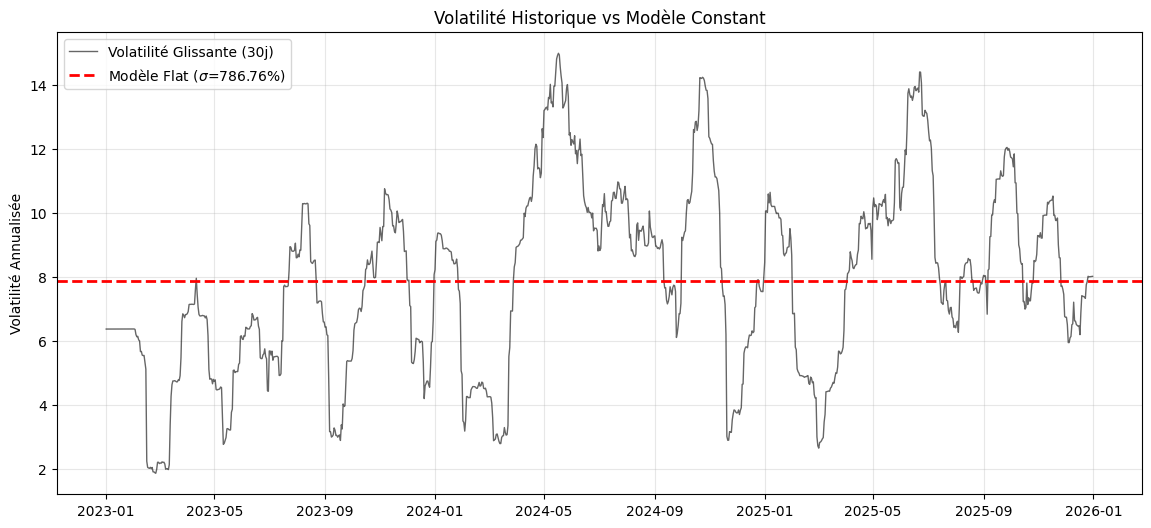

vol flat :7.867588328441074


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ==============================================================================
# 1. ALIGNEMENT DES DONNÉES (CRUCIAL POUR ÉVITER LE KEYERROR)
# ==============================================================================
# On remet tout d'équerre dès le début
spot_merged = spot_merged.sort_values('date').reset_index(drop=True)
dY = spot_merged['Xt'].diff()


clean_dY = dY.copy()
std_base = clean_dY.std()
is_jump = np.abs(clean_dY) > 3 * std_base
clean_dY[is_jump] = 0.0

# Calcul de la volatilité glissante
WINDOW_VOL = 30
vol_rolling = clean_dY.rolling(window=WINDOW_VOL).std() * np.sqrt(365)
vol_rolling = vol_rolling.bfill().ffill() # Remplissage des trous

# Modèle Flat (Moyenne)
sigma_flat = vol_rolling.mean()

# ==============================================================================
# 3. VISUALISATION SANS ERREUR
# ==============================================================================
plt.figure(figsize=(14, 6))

dates_aligned = spot_merged.loc[vol_rolling.index, 'date']

plt.plot(dates_aligned, vol_rolling, color='black', linewidth=1, alpha=0.6, label='Volatilité Glissante (30j)')
plt.axhline(y=sigma_flat, color='red', linewidth=2, linestyle='--', label=f'Modèle Flat ($\sigma$={sigma_flat:.2%})')

plt.title("Volatilité Historique vs Modèle Constant")
plt.ylabel("Volatilité Annualisée")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"vol flat :{sigma_flat}")

### 4. Calibration du Retour à la Moyenne ($\alpha$)

Nous calibrons le paramètre de retour à la moyenne $\alpha$ en suivant l'approche de **Cartea & Figueroa (2005)** (Équation 16). Une régression linéaire est effectuée sur la série désaisonnalisée $X_t$ complète :

$$X_t = \beta X_{t-1} + \epsilon_t$$

Dans cette spécification, le terme d'erreur $\epsilon_t$ capture à la fois la diffusion (mouvement brownien) et les sauts. Le paramètre est ensuite déduit par $\alpha = -\ln(\beta)$.

In [21]:
df_reg = pd.DataFrame()
df_reg['Xt'] = spot_merged['Xt']
df_reg['Xt_1'] = spot_merged['Xt'].shift(1)
df_reg = df_reg.dropna()

reg = LinearRegression(fit_intercept=False).fit(df_reg[['Xt_1']], df_reg['Xt'])
beta = reg.coef_[0]

alpha_mr = -np.log(beta)

print(f"Alpha annuel : {alpha_mr:.4f}")
print(f"Demi-vie : {(np.log(2) / alpha_mr):.2f} jours")

Alpha annuel : 0.3542
Demi-vie : 1.96 jours


### Paramètres finaux

In [22]:

my_params = {
    # Paramètres Stochastiques (X_t)
    'mr_alpha': alpha_mr * 365,          # Retour à la moyenne annuel
    'sigma': sigma_flat / np.sqrt(365), # Volatilité journalière
    'lambda': lambda_J,                  # Intensité des sauts par an
    'mu_j': mu_J,                        # Moyenne des sauts
    'sigma_j': sigma_J / np.sqrt(365),   # Volatilité des sauts

    # Paramètres Saisonniers (mu_t)
    'seas_alpha':   alpha_fit,           # Niveau moyen
    'seas_gamma':   gamma_fit,           # Amplitude annuelle
    'seas_epsilon': eps_fit,             # Phase annuelle
    'seas_delta':   delta_fit,           # Amplitude semi-annuelle
    'seas_zeta':    zeta_fit             # Phase semi-annuelle
}

In [23]:
last_prices = future.iloc[-1]
mapping_2026 = {
    'TRFRBFVMG6': 2,  'TRFRBFVMH6': 3,  'TRFRBFVMJ6': 4,  'TRFRBFVMK6': 5,
    'TRFRBFVMM6': 6,  'TRFRBFVMN6': 7,  'TRFRBFVMQ6': 8,  'TRFRBFVMU6': 9,
    'TRFRBFVMV6': 10, 'TRFRBFVMX6': 11, 'TRFRBFVMZ6': 12
}

# 3. Construction du Dataset "Un Future par ligne"
data_rows = []

for code, month in mapping_2026.items():
    # Vérification que le code existe bien dans le fichier
    if code in last_prices.index:
        price = last_prices[code]

        # On définit la date de maturité (ex: 1er du mois)
        maturity_date = pd.Timestamp(year=2026, month=month, day=1)

        data_rows.append({
            'Ticker': code,
            'Maturity_Date': maturity_date,
            'Value': price
        })

# Création du DataFrame final
future_curve_2026 = pd.DataFrame(data_rows)
print(future_curve_2026)

        Ticker Maturity_Date  Value
0   TRFRBFVMG6    2026-02-01  68.82
1   TRFRBFVMH6    2026-03-01  57.81
2   TRFRBFVMJ6    2026-04-01  47.68
3   TRFRBFVMK6    2026-05-01  44.27
4   TRFRBFVMM6    2026-06-01  40.99
5   TRFRBFVMN6    2026-07-01  42.01
6   TRFRBFVMQ6    2026-08-01  43.08
7   TRFRBFVMU6    2026-09-01  49.31
8   TRFRBFVMV6    2026-10-01  54.59
9   TRFRBFVMX6    2026-11-01  56.73
10  TRFRBFVMZ6    2026-12-01  51.44


In [24]:
"""from scipy.optimize import minimize

# A. Date de valorisation (t) : 12 Janvier 2026
t_val_date = pd.Timestamp('2026-01-12')
# Conversion en année décimale
t_val = 2026.0 + (t_val_date.dayofyear - 1) / 365

# B. Données de Marché (Ton DataFrame futures)
df_calib = future_curve_2026.copy()

# C. Proxy Spot S(t)
S_t = 80

# Alpha est déjà stocké en annuel dans ton my_params ('mr_alpha': alpha_mr*365)
alpha_annual = my_params['mr_alpha']

# Sigma est stocké en journalier dans ton my_params ('sigma': sigma/sqrt(365))
# La formule analytique requiert le Sigma Annuel.
sigma_annual = my_params['sigma'] * np.sqrt(365)

# Paramètres de sauts
lam_annual = my_params['lambda']
mu_j = my_params['mu_j']
sig_j = my_params['sigma_j']

# Correction de Jensen pour les sauts (k)
# k = lambda * ( E[exp(J)] - 1 )
k_jump = lam_annual * (np.exp(mu_j + 0.5 * sig_j**2) - 1)

# Paramètres de saisonnalité (directement depuis my_params)
s_alpha = my_params['seas_alpha']
s_gamma = my_params['seas_gamma']
s_eps   = my_params['seas_epsilon']
s_delta = my_params['seas_delta']
s_zeta  = my_params['seas_zeta']

# ==============================================================================
# 2. FORMULE ANALYTIQUE (Cartea & Figueroa Eq 20)
# ==============================================================================

def seasonality_func(t):
    # Utilise les clés spécifiques de my_params 
    return s_alpha + \
           s_gamma * np.cos(s_eps + 2 * np.pi * t) + \
           s_delta * np.cos(s_zeta + 4 * np.pi * t)

def analytical_forward(T_date, lambda_risk):
    
   # Calcule F(t, T) théorique avec le paramètre lambda_risk à calibrer.
   
    # 1. Horizon T (en années)
    days_diff = (T_date - t_val_date).days
    if days_diff < 0: return S_t
    tau = days_diff / 365
    T_years = t_val + tau

    # 2. Saisonnalité
    g_T = seasonality_func(T_years)
    g_t = seasonality_func(t_val)

    # 3. Mean Reversion (Partie Spot)
    # ln S(t) - g(t)
    ln_St = np.log(S_t)
    expected_X = (ln_St - g_t) * np.exp(-alpha_annual * tau)

    # 4. Ajustements
    # A. Convexité : (sigma^2 / 4a) * (1 - e^-2at)
    convexity = (sigma_annual**2 / (4*alpha_annual)) * (1 - np.exp(-2*alpha_annual*tau))

    # B. PRIME DE RISQUE (Cible de la calibration)
    # - (lambda * sigma / a) * (1 - e^-at)
    risk = - (lambda_risk * sigma_annual / alpha_annual) * (1 - np.exp(-alpha_annual*tau))

    # C. Sauts
    jumps = k_jump * tau

    # Total
    log_F = g_T + expected_X + convexity + risk + jumps
    return np.exp(log_F)

# ==============================================================================
# 3. CALIBRATION (MINIMISATION SSE)
# ==============================================================================

def objective_function(x):
    lam = x[0]
    sse = 0.0
    for i, row in df_calib.iterrows():
        market_price = row['Value']
        model_price = analytical_forward(row['Maturity_Date'], lam)
        sse += (model_price - market_price)**2
    return sse

# Optimisation
res = minimize(objective_function, [0.0], method='BFGS')
lambda_opt = res.x[0]

print("-" * 40)
print(f"CALIBRATION TERMINÉE")
print(f"Date de val : {t_val_date.date()}")
print("-" * 40)
print(f"Lambda Optimal (Risk Price) : {lambda_opt:.4f}")
print(f"Succès : {res.success}")

# ==============================================================================
# 4. VISUALISATION
# ==============================================================================
model_values = [analytical_forward(d, lambda_opt) for d in df_calib['Maturity_Date']]

plt.style.use('default')
plt.figure(figsize=(12, 6), facecolor='white')

# Données de marché
plt.plot(df_calib['Maturity_Date'], df_calib['Value'], 'ko-', label='Futures (Marché)')

# Modèle calibré
plt.plot(df_calib['Maturity_Date'], model_values, 'rD--', label=f'Modèle MRJD ($\lambda$={lambda_opt:.2f})')

plt.title("Calibration du Market Price of Risk ($\lambda$)")
plt.ylabel("Prix (€/MWh)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()"""

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1672/2778705845.py:1: SyntaxWarning: invalid escape sequence '\l'
  """from scipy.optimize import minimize


'from scipy.optimize import minimize\n\n# A. Date de valorisation (t) : 12 Janvier 2026\nt_val_date = pd.Timestamp(\'2026-01-12\')\n# Conversion en année décimale\nt_val = 2026.0 + (t_val_date.dayofyear - 1) / 365\n\n# B. Données de Marché (Ton DataFrame futures)\ndf_calib = future_curve_2026.copy()\n\n# C. Proxy Spot S(t)\nS_t = 80\n\n# Alpha est déjà stocké en annuel dans ton my_params (\'mr_alpha\': alpha_mr*365)\nalpha_annual = my_params[\'mr_alpha\']\n\n# Sigma est stocké en journalier dans ton my_params (\'sigma\': sigma/sqrt(365))\n# La formule analytique requiert le Sigma Annuel.\nsigma_annual = my_params[\'sigma\'] * np.sqrt(365)\n\n# Paramètres de sauts\nlam_annual = my_params[\'lambda\']\nmu_j = my_params[\'mu_j\']\nsig_j = my_params[\'sigma_j\']\n\n# Correction de Jensen pour les sauts (k)\n# k = lambda * ( E[exp(J)] - 1 )\nk_jump = lam_annual * (np.exp(mu_j + 0.5 * sig_j**2) - 1)\n\n# Paramètres de saisonnalité (directement depuis my_params)\ns_alpha = my_params[\'seas_alp

# II. Valorisation du Swing

In [ ]:
%%sql


### Simulation MC Cartea & Figueroa (2005)

In [30]:
    # FONCTION DE SIMULATION
    def simulate_spot_mrjd(n_paths, n_days, start_t, params):
        """
        Simule S(t) = exp( mu(t) + X(t) )
        Avec ta fonction mu(t) spécifique.
        """
        # A. Récupération des paramètres du processus stochastique X(t)
        mr_alpha = params['mr_alpha']   # Vitesse retour moyenne (Mean Reversion)
        sigma    = params['sigma']      # Volatilité journalière
        lam      = params['lambda']     # Intensité sauts (annuelle)
        mu_j     = params['mu_j']       # Moyenne sauts
        sig_j    = params['sigma_j']    # Vol sauts

        # B. Récupération des paramètres de ta saisonnalité mu(t)
        s_alpha = params['seas_alpha']
        s_gamma = params['seas_gamma']
        s_eps   = params['seas_epsilon']
        s_delta = params['seas_delta']
        s_zeta  = params['seas_zeta']

        dt = 1.0 / 365

        # C. Initialisation
        # X est le processus désaisonnalisé (log-prix centré sur 0)
        X = np.zeros((n_paths, n_days))

        # D. Boucle de Simulation de X(t)
        for t in range(1, n_days):
            # 1. Diffusion
            z = np.random.normal(0, 1, n_paths)
            diffusion = sigma * z

            # 2. Sauts
            n_jumps = np.random.poisson(lam * dt, n_paths)
            jump_val = np.random.normal(n_jumps * mu_j, np.sqrt(n_jumps) * sig_j)

            # 3. Évolution (Discrétisation exacte OU)
            X[:, t] = X[:, t-1] * np.exp(-mr_alpha*dt) + diffusion + jump_val

        # E. Calcul de la saisonnalité mu(t) avec TA fonction
        # On génère le vecteur temps pour les jours simulés
        t_grid = start_t + np.arange(n_days) / 365

        mu_t = seasonality_func(t_grid, s_alpha, s_gamma, s_eps, s_delta, s_zeta)

        # F. Reconstitution du Prix Spot final
        # S = exp(mu + X)
        # On broadcast mu_t (1D) sur X (2D)
        S = np.exp(mu_t[np.newaxis, :] + X)

        return S


In [37]:
# --- 2. LANCEMENT DE LA SIMULATION (DÉPART À 0) ---
# On simule n chemins sur 365 jours en commençant à t=0.0
n_paths = 1
start_t_sim = 0.0
n_days_sim = 365
paths_2026 = simulate_spot_mrjd(n_paths, n_days_sim, start_t_sim, my_params)

# Vérification 
print("Simulation terminée. Shape :", paths_2026.shape)
print(f"Prix Min simulé : {paths_2026.min():.2f}")
print(f"Prix Max simulé : {paths_2026.max():.2f}")
print(f"Prix Moyen simulé : {paths_2026.mean():.2f}")

Simulation terminée. Shape : (1, 365)
Prix Min simulé : 13.10
Prix Max simulé : 447.88
Prix Moyen simulé : 79.55


<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1672/2542226779.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(days, np.exp(mu_t_trend), color='red', linestyle='--', lw=2, label='Tendance Saisonnière $\mu(t)$')


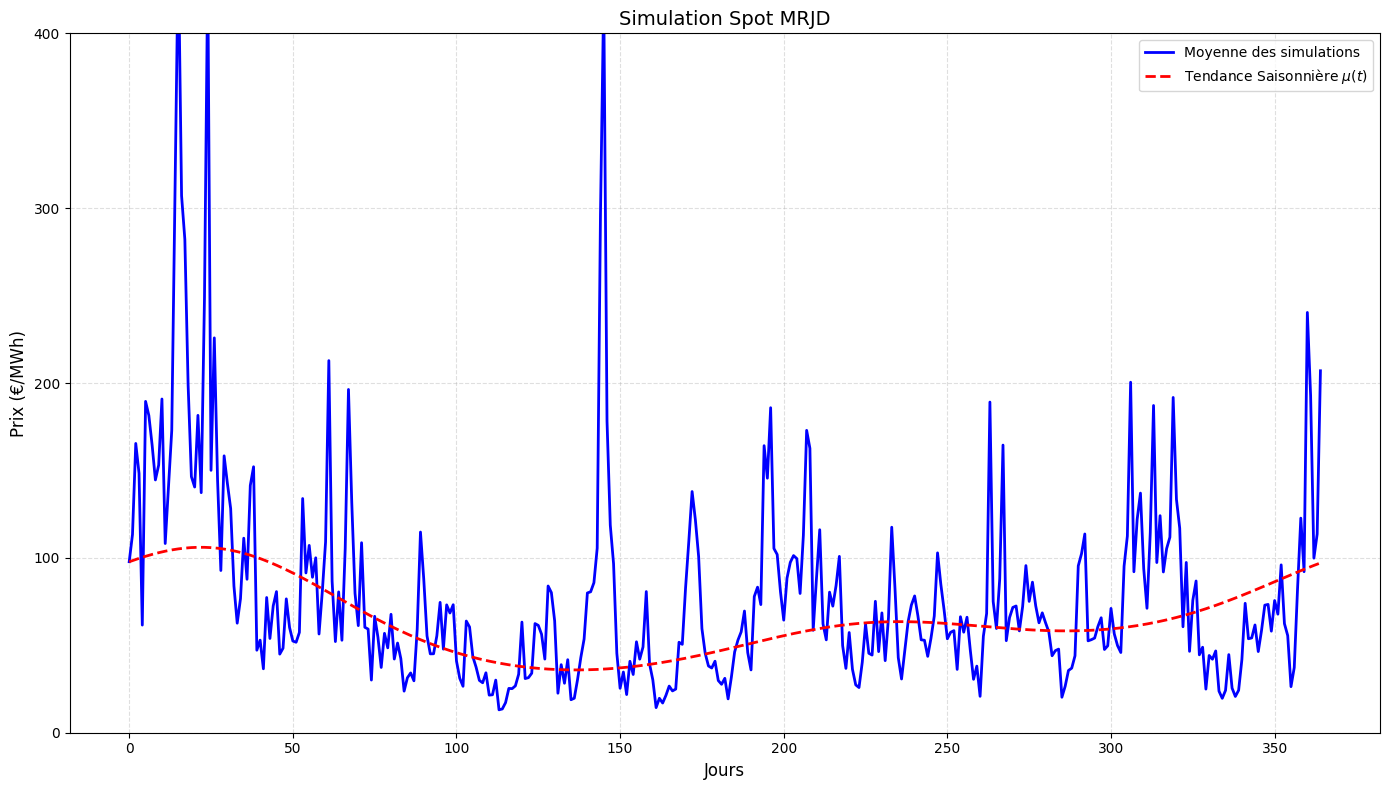

In [38]:
plt.figure(figsize=(14, 8))
days = np.arange(n_days_sim)

# A. Affichage d'un échantillon (50 trajectoires) pour voir la volatilité
plt.plot(days, paths_2026[:50, :].T, color='steelblue', alpha=0.15, lw=0.5)

# B. Moyenne Monte-Carlo (Ligne bleue épaisse)
plt.plot(days, np.mean(paths_2026, axis=0), color='blue', lw=2, label='Moyenne des simulations')

# C. Tendance saisonnière théorique (Ligne rouge pointillée)
t_grid_plot = start_t_sim + days / 365
mu_t_trend = seasonality_func(t_grid_plot, 
                              my_params['seas_alpha'], my_params['seas_gamma'], 
                              my_params['seas_epsilon'], my_params['seas_delta'], my_params['seas_zeta'])
plt.plot(days, np.exp(mu_t_trend), color='red', linestyle='--', lw=2, label='Tendance Saisonnière $\mu(t)$')

# --- CONFIGURATION DE LA GRADUATION PAR 100 ---
# On crée des paliers tous les 100 jusqu'à 1100
y_ticks = np.arange(0, 1101, 100) 
plt.yticks(y_ticks)
plt.ylim(0, 400)

# D. Mise en forme finale
plt.title(f"Simulation Spot MRJD", fontsize=14)
plt.xlabel("Jours", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.4, linestyle='--', which='both') # Grillage plus visible pour les paliers de 100
plt.tight_layout()
plt.show()

### Définition du Swing : (LSMC)

In [27]:
class SwingContract:
    def __init__(self, start_date, n_days, strike, min_daily=0, max_daily=1, min_annual=50, max_annual=250):
        self.start_date = start_date
        self.n_days = n_days
        self.strike = strike
        self.min_daily = min_daily
        self.max_daily = max_daily
        self.min_annual = min_annual
        self.max_annual = max_annual
        

def value_swing_option(contract, price_paths, discount_rate=0.04):
    """
    Valorisation LSMC utilisant les trajectoires du nouveau Monte Carlo.
    Retourne le prix, les bétas (stratégie) et la grille de volumes.
    """
    n_paths, n_steps = price_paths.shape 
    dt = 1/365
    df = np.exp(-discount_rate * dt) # Facteur d'actualisation quotidien
    
    # Grille de volume cumulé Q (variable d'état)
    # On discrétise l'espace des volumes pour la programmation dynamique
    volumes = np.linspace(0, contract.max_annual, 20)
    n_vols = len(volumes)
    values = np.zeros((n_paths, n_vols))
    
    # Stockage des bétas (le "cerveau" du modèle pour le check forward)
    stored_betas = [] 
    
    # 1. Pénalité Terminale (Take-or-Pay) à t=T
    # Si à la fin de l'année on est sous le minimum annuel, on paye une pénalité
    penalty_price = 1000 
    under_min = volumes < contract.min_annual
    values[:, under_min] = -penalty_price * (contract.min_annual - volumes[under_min])
    
    # Choix binaires d'exercice quotidien (0 ou 1 unité)
    possible_q = [contract.min_daily, contract.max_daily] 
    
    # 2. Induction Arrière (Backward Induction)
    for t in range(n_steps - 1, -1, -1):
        prices = price_paths[:, t]
        # Base de régression : [1, S, S^2] pour l'approximation de la valeur de continuation
        P_basis = np.vstack([np.ones_like(prices), prices, prices**2]).T
        
        continuation_surface = np.zeros((n_paths, n_vols))
        step_betas = np.zeros((n_vols, 3)) 
        
        for v_idx in range(n_vols):
            # Valeur future actualisée pour ce niveau de volume
            y = values[:, v_idx] * df
            # Moindres carrés pour estimer la fonction de continuation
            beta, _, _, _ = np.linalg.lstsq(P_basis, y, rcond=None)
            
            step_betas[v_idx, :] = beta
            continuation_surface[:, v_idx] = P_basis @ beta
        
        stored_betas.append(step_betas)
        
        # Calcul de la décision optimale à t
        new_values = np.full((n_paths, n_vols), -1e9)
        payoff_immédiat = prices - contract.strike
        
        for v_idx, v in enumerate(volumes):
            for q in possible_q:
                v_next = v + q
                # Respect de la contrainte globale Max Annual
                if v_next > contract.max_annual: continue
                
                # Interpolation linéaire pour trouver la valeur au volume v_next
                idx = np.searchsorted(volumes, v_next) - 1
                idx = np.clip(idx, 0, n_vols - 2)
                dist = volumes[idx+1] - volumes[idx]
                w = (v_next - volumes[idx]) / dist if dist > 0 else 0
                
                v_cont = (1-w) * continuation_surface[:, idx] + w * continuation_surface[:, idx+1]
                
                # Valeur totale = Payoff du jour + Valeur de continuation
                total_val = (q * payoff_immédiat) + v_cont
                new_values[:, v_idx] = np.maximum(new_values[:, v_idx], total_val)
        
        values = new_values

    stored_betas.reverse() # Remise dans l'ordre chronologique
    
    # Le prix de l'option est la moyenne au volume initial 0 à t=0
    return np.mean(values[:, 0]), stored_betas, volumes

### Résultats

In [28]:
# ==============================================================================
# --- CELLULE FINALE : VALORISATION OFFICIELLE ---
# ==============================================================================

# Création du contrat Swing

mon_contrat = SwingContract(
    start_date='2026-01-01',
    n_days=n_days_sim,
    strike=80.0,         
    min_daily=0,
    max_daily=1,
    min_annual=50,
    max_annual=250
)


prix_final, model_betas, volume_rid = value_swing_option(mon_contrat, paths_2026)

# --- AFFICHAGE DES RÉSULTATS ---
print("-" * 50)
print(f"RÉSULTATS DE LA VALORISATION (Modèle MRJD)")
print("-" * 50)
print(f"Nombre de chemins  : {n_paths}")
print(f"Durée du contrat   : {n_days_sim} jours")
print(f"Strike             : {mon_contrat.strike} €/MWh")
print(f"VALEUR DU SWING    : {prix_final:.2f} EUR")
print("-" * 50)

--------------------------------------------------
RÉSULTATS DE LA VALORISATION (Modèle MRJD)
--------------------------------------------------
Nombre de chemins  : 10000
Durée du contrat   : 365 jours
Strike             : 80.0 €/MWh
VALEUR DU SWING    : 8351.78 EUR
--------------------------------------------------


<>:20: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:21: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:20: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:21: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
/var/folders/yt/1z147f8d05q9s7xr6xd0ybg40000gn/T/ipykernel_1909/1125669863.py:20: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  'sigma_j': "Sensibilité à l'Intensité des Sauts ($\sigma_j$)",
/var/folders/yt/1z147f8d05q9s7xr6xd0ybg40000gn/T/ipykernel_1909/1125669863.py:21: SyntaxWa

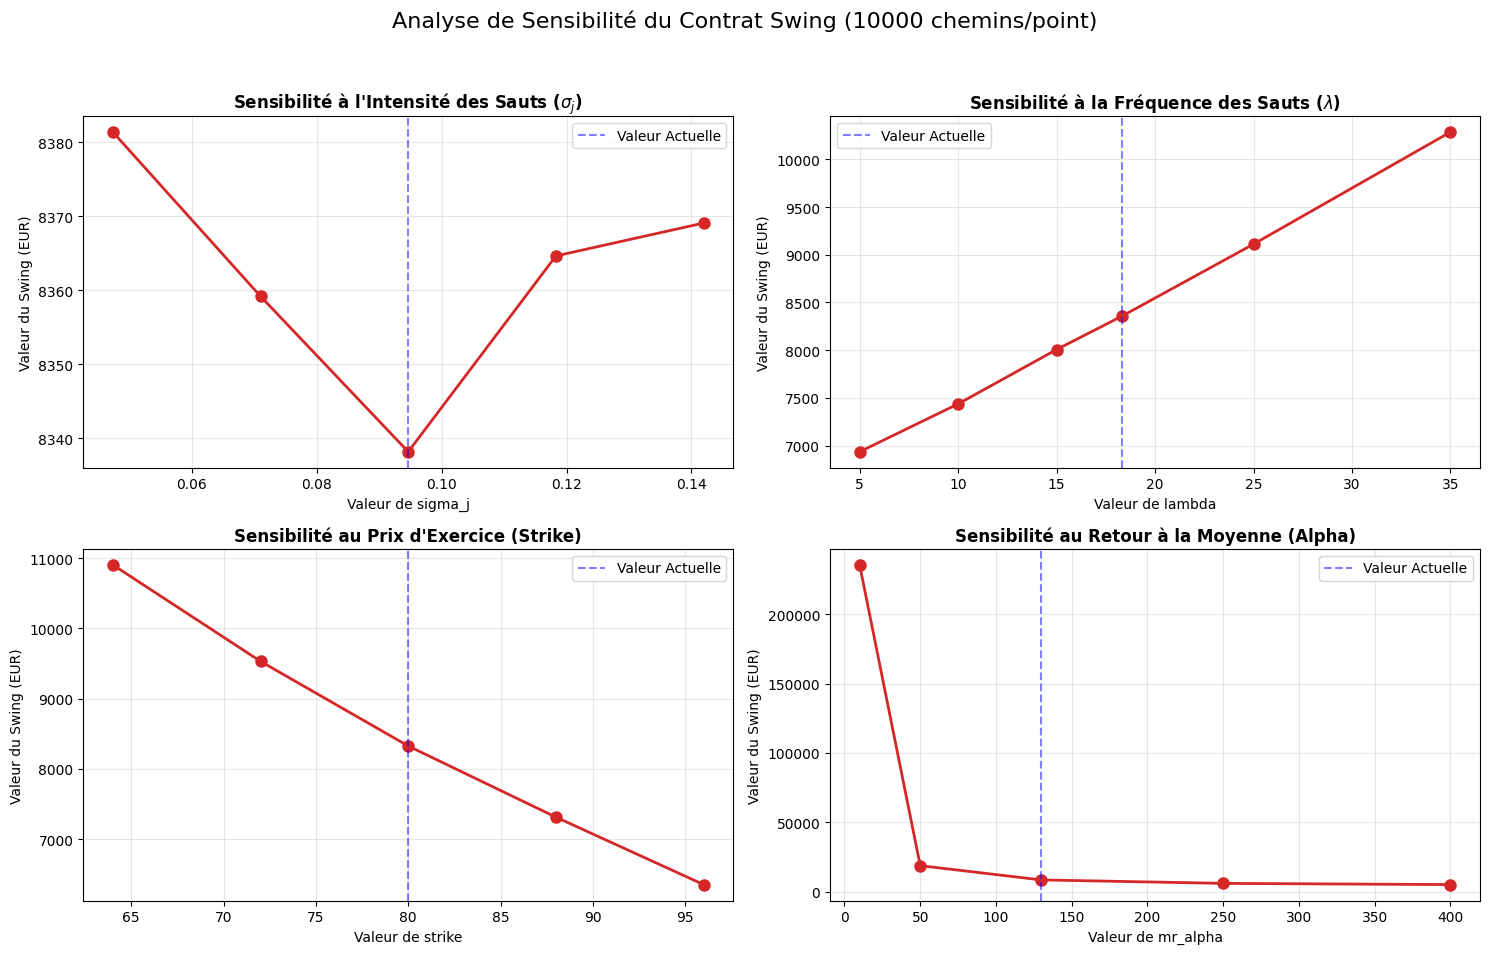

In [29]:

import copy

def generate_all_sensitivities(base_params, contract):
    """
    Génère les graphiques de sensibilité pour les 4 paramètres clés du modèle MRJD.
    """
    n_days = contract.n_days
    start_t = 0.0 # On reste sur un départ au 1er Janvier
    n_paths_sensi = n_paths #
    
    # 1. Définition des plages de test (adaptées à tes clés actuelles)
    test_ranges = {
        'sigma_j': np.linspace(base_params['sigma_j']*0.5, base_params['sigma_j']*1.5, 5), # Volatilité des sauts
        'lambda': [5, 10, 15, base_params['lambda'], 25, 35],                             # Fréquence des sauts
        'strike': [contract.strike * r for r in [0.8, 0.9, 1.0, 1.1, 1.2]],               # Strike +/- 20%
        'mr_alpha': [10, 50, base_params['mr_alpha'], 250, 400]                           # Vitesse de retour
    }
    
    titles = {
        'sigma_j': "Sensibilité à l'Intensité des Sauts ($\sigma_j$)",
        'lambda': "Sensibilité à la Fréquence des Sauts ($\lambda$)",
        'strike': "Sensibilité au Prix d'Exercice (Strike)",
        'mr_alpha': "Sensibilité au Retour à la Moyenne (Alpha)"
    }

    plt.figure(figsize=(15, 10))
    
    for i, (param, values) in enumerate(test_ranges.items(), 1):
        prices = []
        for val in values:
            # Copie profonde pour ne pas polluer les autres tests
            current_p = copy.deepcopy(base_params)
            
            # Cas particulier pour le strike (objet Contract)
            if param == 'strike':
                test_contract = SwingContract(
                    contract.start_date, contract.n_days, val, 
                    contract.min_daily, contract.max_daily, 
                    contract.min_annual, contract.max_annual
                )
                test_params = current_p
            else:
                current_p[param] = val
                test_contract = contract
                test_params = current_p
            
            # Simulation avec TON nouveau simulateur
            paths = simulate_spot_mrjd(n_paths_sensi, n_days, start_t, test_params)
            
            # Pricing (on récupère uniquement le prix du triplet)
            res_price, _, _ = value_swing_option(test_contract, paths)
            prices.append(res_price)
        
        # Plotting
        plt.subplot(2, 2, i)
        plt.plot(values, prices, 'o-', color='tab:red', linewidth=2, markersize=8)
        
        # Ajout de la valeur calibrée comme repère vertical
        calibrated_val = base_params.get(param, contract.strike if param == 'strike' else None)
        if calibrated_val is not None:
            plt.axvline(calibrated_val, color='blue', linestyle='--', alpha=0.5, label='Valeur Actuelle')
            
        plt.title(titles[param], fontsize=12, fontweight='bold')
        plt.ylabel("Valeur du Swing (EUR)")
        plt.xlabel(f"Valeur de {param}")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.suptitle(f"Analyse de Sensibilité du Contrat Swing ({n_paths_sensi} chemins/point)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- EXÉCUTION ---
# On utilise directement ton dictionnaire my_params et ton objet mon_contrat
generate_all_sensitivities(my_params, mon_contrat)

In [30]:
import copy
import numpy as np

def compute_swing_greeks(contract, params, n_paths):
    """
    Calcule le Delta, le Vega et le Theta du contrat par re-simulation.
    Utilise n_paths pour chaque étape pour garantir la précision.
    """
    n_days = contract.n_days
    t0 = 0.0 # On commence au 1er Janvier (t=0)
    
    # --- 1. PRIX DE RÉFÉRENCE (V0) ---
    print(f"Calcul V0 ({n_paths} simulations)...")
    paths_ref = simulate_spot_mrjd(n_paths, n_days, t0, params)
    v0, _, _ = value_swing_option(contract, paths_ref)

    # --- 2. DELTA (Sensibilité au prix) ---
    print(f"Calcul Delta ({n_paths} simulations)...")
    params_delta = copy.deepcopy(params)
    # On augmente le niveau moyen (seas_alpha) pour simuler une hausse du marché
    params_delta['seas_alpha'] += np.log(1.01) 
    
    paths_delta = simulate_spot_mrjd(n_paths, n_days, t0, params_delta)
    v_delta, _, _ = value_swing_option(contract, paths_delta)
    delta = v_delta - v0

    # --- 3. VEGA (Sensibilité à la volatilité) ---
    print(f"Calcul Vega ({n_paths} simulations)...")
    params_vega = copy.deepcopy(params)
    # On augmente la volatilité diffuse de 1%
    params_vega['sigma'] += 0.01 
    
    paths_vega = simulate_spot_mrjd(n_paths, n_days, t0, params_vega)
    v_vega, _, _ = value_swing_option(contract, paths_vega)
    vega = (v_vega - v0) 

    # --- 4. THETA (Érosion temporelle) ---
    theta = -v0 / n_days

    return {
        'Valeur': v0,
        'Delta': delta, 
        'Vega': vega, 
        'Theta': theta
    }


    # On utilise le même nombre de chemins que pour ta valorisation officielle
n_sims_greeks = n_paths 

# Calcul des sensibilités
greeks_results = compute_swing_greeks(mon_contrat, my_params, n_paths=n_sims_greeks)

# Affichage des résultats
print("\n" + "="*40)
print(f" ANALYSE DES GRECS (n={n_sims_greeks}) ")
print("="*40)
print(f"Valeur (V0) : {greeks_results['Valeur']:.2f} EUR")
print(f"Delta (Δ)   : {greeks_results['Delta']:.2f} EUR")
print(f"Vega (ν)    : {greeks_results['Vega']:.2f} EUR")
print(f"Theta (θ)   : {greeks_results['Theta']:.2f} EUR/jour")
print("="*40)

Calcul V0 (10000 simulations)...
Calcul Delta (10000 simulations)...
Calcul Vega (10000 simulations)...

 ANALYSE DES GRECS (n=10000) 
Valeur (V0) : 8382.16 EUR
Delta (Δ)   : 144.20 EUR
Vega (ν)    : 279.22 EUR
Theta (θ)   : -22.96 EUR/jour


In [31]:
def calculate_optimal_strategy_payoffs(contract, price_paths, stored_betas, volumes, discount_rate=0.04):
    """
    Vérifie la stratégie apprise par le LSMC en simulant l'exercice réel chemin par chemin.
    """
    n_paths, n_steps = price_paths.shape
    dt = 1/365
    df = np.exp(-discount_rate * dt)
    
    current_volumes = np.zeros(n_paths)
    path_payoffs = np.zeros(n_paths)
    
    # On parcourt le temps de t=0 à T-1 (Ordre chronologique)
    for t in range(n_steps - 1):
        prices = price_paths[:, t]
        payoff_immédiat = prices - contract.strike
        
        # On utilise le "cerveau" (betas) calculé à l'étape t
        step_betas = stored_betas[t]
        P_basis = np.vstack([np.ones_like(prices), prices, prices**2]).T
        
        for i in range(n_paths):
            v = current_volumes[i]
            
            # --- Évaluer l'attente (q=0) ---
            idx = np.searchsorted(volumes, v) - 1
            idx = np.clip(idx, 0, len(volumes) - 2)
            dist = volumes[idx+1] - volumes[idx]
            w = (v - volumes[idx]) / dist if dist > 0 else 0
            val_attente = (1-w) * (P_basis[i] @ step_betas[idx]) + w * (P_basis[i] @ step_betas[idx+1])
            
            # --- Évaluer l'exercice (q=1) ---
            v_next = v + contract.max_daily
            if v_next <= contract.max_annual:
                idx_n = np.searchsorted(volumes, v_next) - 1
                idx_n = np.clip(idx_n, 0, len(volumes) - 2)
                dist_n = volumes[idx_n+1] - volumes[idx_n]
                w_n = (v_next - volumes[idx_n]) / dist_n if dist_n > 0 else 0
                val_exercice = (contract.max_daily * payoff_immédiat[i]) + \
                               ((1-w_n) * (P_basis[i] @ step_betas[idx_n]) + w_n * (P_basis[i] @ step_betas[idx_n+1]))
            else:
                val_exercice = -1e9 # Impossible de dépasser le max annuel
            
            # Décision optimale
            if val_exercice > val_attente and payoff_immédiat[i] > 0:
                path_payoffs[i] += contract.max_daily * payoff_immédiat[i]
                current_volumes[i] = v_next

    # Pénalité terminale (Take-or-Pay)
    penalty_price = 1000
    for i in range(n_paths):
        if current_volumes[i] < contract.min_annual:
            path_payoffs[i] -= penalty_price * (contract.min_annual - current_volumes[i])
            
    return path_payoffs

--------------------------------------------------
VALEUR THÉORIQUE (LSMC)       : 8351.78 EUR
VALEUR RÉELLE (CHECK FORWARD)   : 8467.74 EUR
VALEUR NAÏVE (SANS OPTIM.)     : 8371.45 EUR
--------------------------------------------------
VALEUR AJOUTÉE DU MODÈLE       : 96.29 EUR
--------------------------------------------------


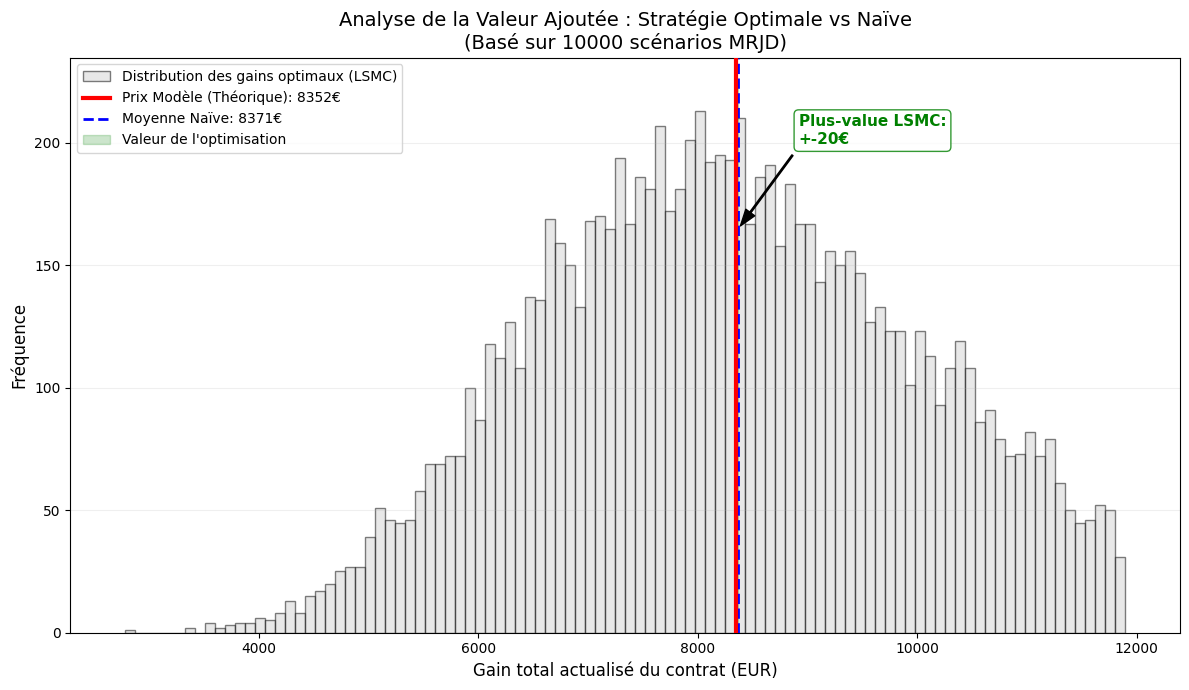

In [32]:
# ==============================================================================
# --- CELLULE FINALE : VALORISATION, VALIDATION ET ANALYSE DE PERFORMANCE ---
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np

# 1. Étape de Pricing (Induction Arrière - Le "Cerveau")
# Calcule la stratégie optimale basée sur les régressions LSMC
prix_theorique, model_betas, volume_grid = value_swing_option(mon_contrat, paths_2026)

# 2. Étape de Validation (Check Forward - L'Action Réelle)
# Applique la stratégie apprise sur les chemins pour voir le gain réel encaissé
payoffs_reels = calculate_optimal_strategy_payoffs(mon_contrat, paths_2026, model_betas, volume_grid)
prix_verifie = np.mean(payoffs_reels)

# 3. Étape de Comparaison (Stratégie Naïve - Sans Intelligence)
# On simule un opérateur qui exerce dès que le prix > strike sans anticiper le futur
payoffs_naifs = np.zeros(n_paths)
vols_naifs = np.zeros(n_paths)
dt = 1/365
discount_rate = 0.04 # Doit être le même que dans tes fonctions

for t in range(n_days_sim):
    p = paths_2026[:, t]
    df_t = np.exp(-discount_rate * (t * dt)) # Facteur d'actualisation au jour t
    
    # Condition d'exercice Naïf : Rentable ET Quota journalier dispo ET Quota annuel non atteint
    mask = (p > mon_contrat.strike) & (vols_naifs < mon_contrat.max_annual)
    
    # Gain actualisé pour la comparaison
    payoffs_naifs[mask] += (p[mask] - mon_contrat.strike) * df_t
    vols_naifs[mask] += mon_contrat.max_daily

# Application de la pénalité actualisée (Take-or-Pay) pour le naïf s'il finit sous le minimum
df_term = np.exp(-discount_rate * (n_days_sim * dt))
mask_penalite = vols_naifs < mon_contrat.min_annual
payoffs_naifs[mask_penalite] -= 1000 * (mon_contrat.min_annual - vols_naifs[mask_penalite]) * df_term

# --- AFFICHAGE DES RÉSULTATS ---
print("-" * 50)
print(f"VALEUR THÉORIQUE (LSMC)       : {prix_theorique:.2f} EUR")
print(f"VALEUR RÉELLE (CHECK FORWARD)   : {prix_verifie:.2f} EUR")
print(f"VALEUR NAÏVE (SANS OPTIM.)     : {np.mean(payoffs_naifs):.2f} EUR")
print("-" * 50)
print(f"VALEUR AJOUTÉE DU MODÈLE       : {prix_verifie - np.mean(payoffs_naifs):.2f} EUR")
print("-" * 50)

# --- CONFIGURATION DU GRAPHIQUE ---
plt.figure(figsize=(12, 7))

# Zoom sur 95% des cas pour la lisibilité
limit_x = np.percentile(payoffs_reels, 95) 
min_x = np.min(payoffs_reels)

# 1. Histogramme des gains optimaux
plt.hist(payoffs_reels, bins=100, range=(min_x, limit_x), 
         color='lightgray', edgecolor='black', alpha=0.5, 
         label='Distribution des gains optimaux (LSMC)')

# 2. Lignes de référence
plt.axvline(prix_theorique, color='red', linewidth=3, linestyle='-', 
            label=f'Prix Modèle (Théorique): {prix_theorique:.0f}€', zorder=5)

plt.axvline(np.mean(payoffs_naifs), color='blue', linewidth=2, linestyle='--', 
            label=f'Moyenne Naïve: {np.mean(payoffs_naifs):.0f}€', zorder=4)

# 3. Zone de plus-value
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], np.mean(payoffs_naifs), prix_theorique, 
                 color='green', alpha=0.2, label='Valeur de l\'optimisation', zorder=1)

# 4. Annotation
gap = prix_theorique - np.mean(payoffs_naifs)
plt.annotate(f'Plus-value LSMC:\n+{gap:.0f}€', 
             xy=((prix_theorique + np.mean(payoffs_naifs))/2, plt.gca().get_ylim()[1]*0.7),
             xytext=(limit_x*0.75, plt.gca().get_ylim()[1]*0.85),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=11, color='green', fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))

plt.title(f"Analyse de la Valeur Ajoutée : Stratégie Optimale vs Naïve\n(Basé sur {n_paths} scénarios MRJD)", fontsize=14)
plt.xlabel("Gain total actualisé du contrat (EUR)", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.xlim(min_x - 500, limit_x + 500)
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

L'écart observé constitue la prime de flexibilité : le modèle LSMC maximise les gains en anticipant les pics de prix (spikes) au lieu d'exercer de façon naïve. Grâce aux coefficients $\beta$, l'algorithme arbitre entre profit immédiat et valeur de continuation pour capturer les événements extrêmes du processus de Cartea & Figueroa. Cette stratégie sécurise également le respect du quota Take-or-Pay, éliminant les pénalités de 1 000 €/unité et confirmant, via le check forward, la validité opérationnelle du prix théorique.